In [1]:
from os import listdir
from os.path import isfile, join
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from os import walk
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import scale
from collections import Counter
rowsx = []
yx = []


In [2]:
with open("./data/train.csv", 'r', encoding='latin1') as csv1:
    # creating a csv reader object
    csvreader1 = csv.reader(csv1)
    # extracting each data row one by one
    for row in csvreader1:
        rows1 = []
        for i in range(1, len(row)-9):
            for j in row[i].split("\n"):
                    rows1.append(j)
        yx.append(row[0])
        del (row[0])
        rowsx.append(rows1)

print("done")



done


In [3]:
embeddings = Word2Vec(vector_size=200, min_count=3)
embeddings.build_vocab([sentence for sentence in rowsx])
embeddings.train([sentence for sentence in rowsx],
                 total_examples=embeddings.corpus_count,
                 epochs=embeddings.epochs)


gen_tfidf = TfidfVectorizer(analyzer=lambda x: x, min_df=3)
matrix = gen_tfidf.fit_transform([sentence   for sentence in rowsx])
tfidf_map = dict(zip(gen_tfidf.get_feature_names(), gen_tfidf.idf_))
print(len(tfidf_map))



19212


C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
def encode_sentence(tokens, emb_size):
    _vector = np.zeros((1, emb_size))
    length = 0
    for word in tokens:
        try:
            _vector += embeddings.wv[word].reshape((1, emb_size)) * tfidf_map[word]
            length += 1
        except KeyError:
            continue
        break

    if length > 0:
        _vector /= length

    return _vector



In [5]:
x_train = scale(np.concatenate([encode_sentence(ele, 200) for ele in map(lambda x: x, rowsx)]))

print(x_train.shape)

(474824, 200)


done


C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated

C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Logesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; ge

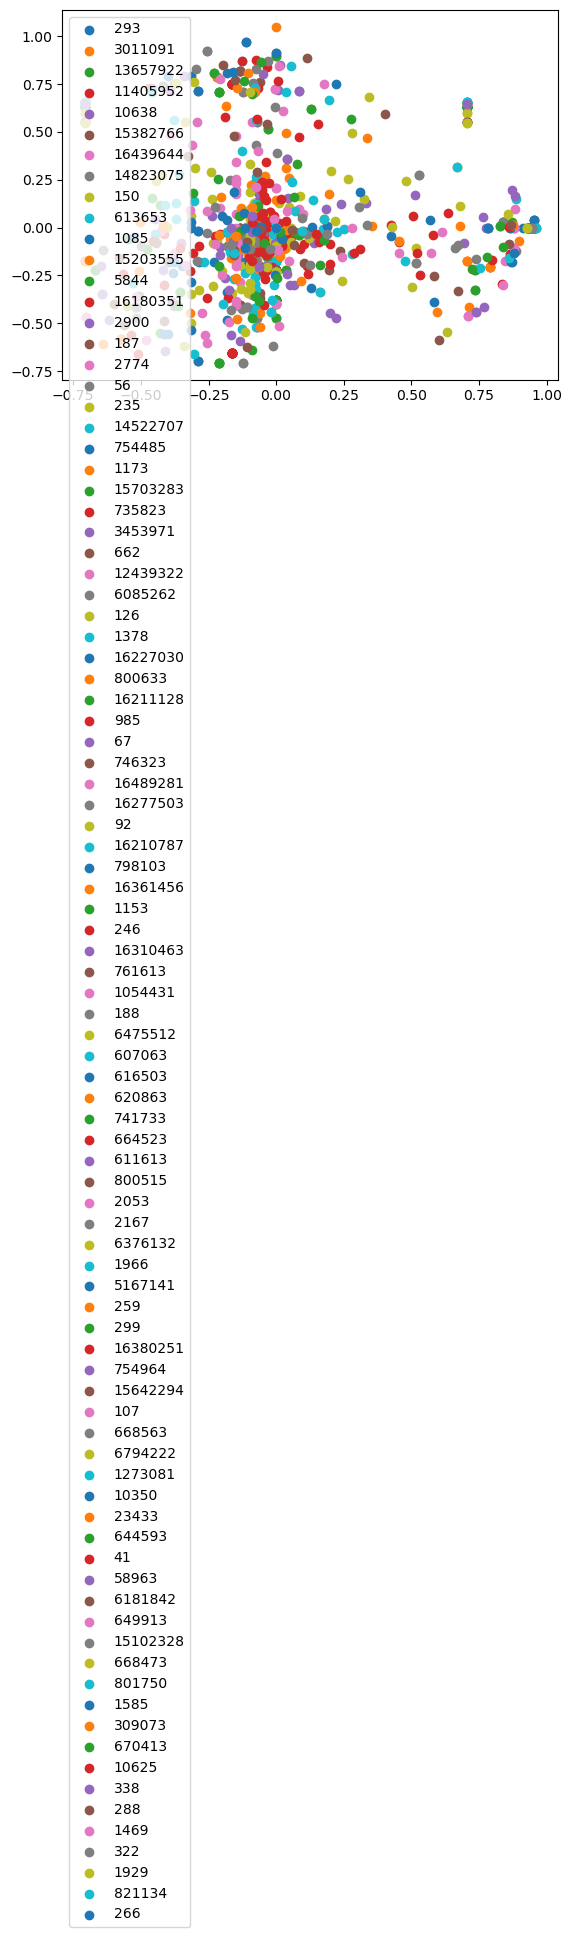

In [6]:
modelknn = KNeighborsClassifier(n_neighbors=1)
modelknn.fit(x_train,yx)
print("done")


rowsx1 = []
with open("./data/sample_test.csv", 'r', encoding='latin1') as csv1:

    csvreader1 = csv.reader(csv1)
    # extracting each data row one by one
    for row in csvreader1:
        rows1 = []
        for i in range(1, len(row)-9):
            for j in row[i].split("\n"):
                rows1.append(j)
        del (row[0])
        rowsx1.append(rows1)
x_test = scale(np.concatenate([encode_sentence(ele, 200) for ele in map(lambda x: x, rowsx1)]))

predicted_labels_knn = modelknn.predict(x_test)
counts = Counter(predicted_labels_knn)

dict = {}
for i in counts:
    dict[i] = []

for i in range(0,len(predicted_labels_knn)):
    dict[predicted_labels_knn[i]].extend(rowsx[i])
rows1 =[]
fig, ax1 = plt.subplots()
for i in counts:
    vectorizer = TfidfVectorizer(stop_words='english')
    vect = vectorizer.fit_transform(dict[i])
    count_vect_df = pd.DataFrame(vect.todense(), columns=vectorizer.get_feature_names())

    f = 0
    for i1 in count_vect_df.shape:
        if i1==1:
            f=1
            break
    if f==1:
        continue

    pca = PCA(n_components=2).fit(count_vect_df)

    data2D = pca.transform(count_vect_df)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(counts)))

    x=""
    x+=i
    ax1.scatter(data2D[:,0],data2D[:,1],label=x)
ax1.legend()
plt.savefig("./results/visualization.png")